<a href="https://colab.research.google.com/github/aarondelgiudice/thinkful_data_bootcamp/blob/master/unit_7/capstone/7_1e_contextual_embeddings.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Lyric Contextual Embeddings
- Embedding Vectors
- Model Embeddings


For our final approach we'll use contextual embeddings to model our lyric data. We'll use ELMo to generate 1024 dimensional embedding vectors for each song. We can then use those vectors as features to model our target variable.

Rather than using the cleaned *and* parsed lyric data, we'll use only the cleaned lyric data. After parsing, some of the lyrics are too short to generate meaningful vectors. Longer texts--such as chapters of a novel or newspaper articles--are better suited for this approach.

Once we've generated our embedding vectors, we'll model them with a neural network using Keras. We'll model both the embeddings alone and in addition to Spotify's audio features and compare our results to a supervised model. For the sake of brevity, we'll only use the gradient boosted classifier as our model, as it was the strongest classifier of the our last two approaches (audio features and lyric NLP). We'll compare the results of our two feature sets and see how well our embedding vectors are able to predict a song's mood.

## Load Data

In [2]:
# load packages
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
#%matplotlib inline
import seaborn as sns
sns.set_style("darkgrid")

from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import GradientBoostingClassifier

from sklearn.metrics import precision_recall_curve, f1_score
from sklearn.metrics import auc, average_precision_score
from sklearn.metrics import roc_curve, roc_auc_score

from keras import Sequential
from keras.layers import Dense

Using TensorFlow backend.


In [4]:
filename = "spotify_lyrics_clean"
df_lyrics = pd.read_csv(filename + ".csv", index_col=0)
df_lyrics.reset_index(drop=True, inplace=True)

print(df_lyrics.shape)
print(df_lyrics.dropna().shape)
df_lyrics.head()

(2990, 11)
(2990, 11)


,id,artist,track,lyrics_raw,length_raw,lyrics_clean,length_clean,lyrics_parsed,length_parsed,lyrics_nostops,length_nostops
0,7eElVgPcxDqmgGrSwVFI74,lorde,sober,"[Intro]\nNight, midnight, lose my mind\nNight,...",2485,night midnight lose my mind night midnight lo...,2275,"[' ', 'night', 'midnight', 'lose', '-PRON-', '...",494,"[' ', 'night', 'midnight', 'lose', 'mind', 'ni...",187
1,02oAUzv4M0ItuTDy2RT3IT,lorde,homemade dynamite,[Verse 1]\nA couple rebel top gun pilots\nFlyi...,1795,couple rebel top gun pilots flying with nowhe...,1621,"[' ', 'couple', 'rebel', 'top', 'gun', 'pilot'...",309,"[' ', 'couple', 'rebel', 'gun', 'pilot', 'fly'...",169
2,5q4BpnMrYEFzLO0dYODj6J,lorde,the louvre,"[Verse 1]\nWell, summer slipped us underneath ...",1824,well summer slipped us underneath her tongue ...,1665,"[' ', 'well', 'summer', 'slip', '-PRON-', 'und...",334,"[' ', 'summer', 'slip', 'underneath', 'tongue'...",151
3,6Kkt27YmFyIFrcX3QXFi2o,lorde,liability,"[Intro]\nOne, two\n\n[Verse 1]\nBaby really hu...",1305,one two baby really hurt me crying in the tax...,1157,"[' ', 'one', 'two', 'baby', 'really', 'hurt', ...",242,"[' ', 'baby', 'hurt', 'cry', 'taxi', 'don', 'w...",101
4,1Dp7JGFNjvg8Nk0CtMCcnr,lorde,hard feelings loveless,Hard Feelings\n\n(Go back and tell it)\n\nPlea...,2386,hard feelings go back and tell it please could...,2189,"['hard', 'feeling', 'go', 'back', 'and', 'tell...",458,"['hard', 'feeling', 'tell', 'tender', 'sit', '...",244


In [5]:
filename = "spotify_features"
Audio_features = pd.read_csv(filename + ".csv", index_col=0)

Audio_features.reset_index(drop=True, inplace=True)
print(Audio_features.shape)
print(Audio_features.dropna().shape)
Audio_features.head()

(2990, 18)
(2990, 18)


,id,target,acousticness,danceability,duration_ms,energy,explicit,instrumentalness,key,liveness,loudness,mode,popularity,speechiness,tempo,time_signature,valence,year
0,7eElVgPcxDqmgGrSwVFI74,0,0.1730,0.796,197236,0.467,True,0.004110,6,0.1260,-10.369,1,59,0.1810,107.901,4,0.516,2017
1,02oAUzv4M0ItuTDy2RT3IT,0,0.2870,0.771,189796,0.431,True,0.000003,10,0.0934,-5.423,1,59,0.0577,107.047,4,0.268,2017
2,5q4BpnMrYEFzLO0dYODj6J,0,0.2390,0.664,271088,0.382,False,0.007490,0,0.0943,-9.977,1,61,0.0470,123.214,4,0.126,2017
3,6Kkt27YmFyIFrcX3QXFi2o,0,0.9200,0.587,171728,0.229,False,0.000000,10,0.1000,-11.254,0,69,0.1280,75.670,4,0.379,2017
4,1Dp7JGFNjvg8Nk0CtMCcnr,0,0.0328,0.487,367391,0.445,True,0.010400,1,0.0778,-10.959,0,60,0.1130,97.031,4,0.180,2017


In [0]:
assert (Audio_features.index == df_lyrics.index).all()

In [7]:
filename = "spotify_embeddings"
df_emb = pd.read_csv(filename + ".csv", index_col=0)
df_emb.reset_index(inplace=True)
print(df_emb.shape)
print(df_emb.dropna().shape)
df_emb.head()

(2990, 1025)
(2990, 1025)


,id,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,...,984,985,986,987,988,989,990,991,992,993,994,995,996,997,998,999,1000,1001,1002,1003,1004,1005,1006,1007,1008,1009,1010,1011,1012,1013,1014,1015,1016,1017,1018,1019,1020,1021,1022,1023
0,7eElVgPcxDqmgGrSwVFI74,-1.176089,-0.107737,-0.569370,-0.250905,-0.196079,0.233768,0.643306,1.164762,-0.953797,0.885341,0.233456,1.157343,-1.184159,2.234673,1.082309,1.509842,1.017656,0.275086,0.189763,0.016859,-0.937232,0.386363,-0.124789,-0.556945,-0.054143,-0.929406,-0.012605,0.002390,0.076078,1.339858,-0.044450,0.330110,0.442595,0.388205,-0.376086,0.700518,0.621598,0.748061,-0.216787,...,0.432884,2.003630,-0.852997,-0.298621,-1.123024,-1.059595,-1.441275,0.095546,2.634760,0.384049,-1.075117,-1.467201,-0.828077,-1.442020,0.099294,0.082079,1.334333,1.647908,-2.649877,0.834402,2.780420,0.148964,-0.253208,-1.001865,3.024287,-0.675499,-0.921162,-0.861756,1.483587,0.678036,0.922910,1.469242,0.220669,-0.197054,1.732071,-2.546426,1.506400,0.784334,3.248197,0.849743
1,02oAUzv4M0ItuTDy2RT3IT,-0.818456,-0.335162,-0.709084,-0.453882,-0.044109,-0.442736,0.629614,1.860680,-0.421865,1.260538,0.633872,1.731610,-0.870405,1.403824,2.325687,1.376182,0.929350,1.006097,0.436990,-0.342039,-0.436087,0.256072,0.461765,-1.524332,-0.195616,-0.076263,-0.307228,-0.743518,-0.357217,0.622497,0.169596,0.113535,1.616498,0.245950,0.090101,1.020024,0.232876,0.335385,-0.841537,...,1.132815,1.599117,1.513349,0.153504,-0.541403,-0.416096,-0.143429,0.899270,2.127211,-0.448340,-0.843154,0.131879,-1.112293,-0.696016,-0.302286,-0.670839,0.732956,1.625931,-1.732838,0.208377,2.225998,0.753254,-0.109293,-1.513544,2.599236,-0.731308,-1.567038,-0.648135,0.277275,-0.293433,-1.702874,1.796735,-0.916728,0.155971,1.281588,-2.694204,1.638449,-0.664250,2.543686,1.326874
2,5q4BpnMrYEFzLO0dYODj6J,-0.878218,0.282790,-0.808863,-0.433924,0.407604,-0.123266,1.535059,2.379490,-0.050003,1.327469,0.951804,1.565531,-2.178823,2.941031,2.310419,0.691588,0.846726,0.990229,-0.498455,-0.957336,-0.606049,0.509263,-0.357404,-0.061091,-0.657854,0.445772,0.291457,-0.649670,-0.397943,0.907033,0.644040,1.077925,0.929998,-0.379858,-0.019066,1.889962,-0.469290,0.961969,-0.685247,...,0.403733,1.477038,-0.157647,-0.359438,-0.464443,-1.103283,-0.482082,-0.203326,2.872298,0.271690,-0.083094,-0.986870,-1.383118,-1.817282,-0.450602,0.486150,1.122400,3.002925,-2.615089,-0.075313,3.189983,0.860678,-1.037161,-0.968324,2.666715,-0.871589,-1.646715,-1.006850,1.233344,1.212906,-0.033491,1.689362,0.355652,-0.423844,1.539076,-1.454237,1.154802,0.642763,3.268840,1.259202
3,6Kkt27YmFyIFrcX3QXFi2o,-0.466507,0.792432,-0.494447,-0.100590,0.546727,-0.253614,0.794765,2.198832,-0.234965,0.627541,0.867905,1.829224,-1.905063,2.337999,1.501105,0.749387,1.298659,0.994754,-0.205810,-0.534288,-0.753254,0.670505,0.460462,-0.790256,-0.331815,0.215781,-0.252302,-1.027334,-0.459904,1.226175,0.722869,0.377776,0.561733,-0.383966,1.132673,1.598741,-0.868457,0.226428,-0.208647,...,0.330872,1.053059,0.763765,-0.465366,-0.088132,-0.982575,-0.554920,-0.862160,1.764676,0.451022,-0.289202,-0.921953,-1.331076,-2.114232,-0.110930,0.491957,0.588337,1.671226,-2.189916,0.884421,2.443677,0.334962,-0.400248,-1.403574,2.521202,-0.352487,-0.814183,-1.534589,0.717943,0.148626,0.648566,1.175033,0.786978,-0.146593,0.475641,-2.374639,0.846798,0.717558,3.282399,1.231623
4,1Dp7JGFNjvg8Nk0CtMCcnr,-0.821989,1.116456,-0.099389,0.346411,0.864321,-0.394252,0.421176,1.416335,-0.827872,1.231101,0.509105,1.946500,-1.710877,1.770404,1.396535,1.170612,0.788084,1.045131,-0.393810,-0.345053,-0.226228,1.440690,0.052912,-0.692761,-0.927573,-0.514701,-0.332411,-1.399359,-0.215262,1.182957,0.182795,0.323677,0.178181,0.203908,0.652043,1.405541,-0.505214,-0.201571,-0.538093,...,0.315548,1.845462,0.990229,-0.891164,-0.580832,-0.711713,0.014514,-0.373449,2.832333,1.111731,-0.253617,-1.314475,-0.187999,-1.473013,0.349294,1.221470,1.054354,1.784692,-1.183902,0.589098,1.978302,0.

## 1024-Dimension Embedding Vectors

In [0]:
! pip install "tensorflow>=1.7.0"
! pip install tensorflow-hub

In [0]:
# install ELMo
! pip install allennlp

     |████████████████████████████████| 5.7MB 1.8MB/s 
     |████████████████████████████████| 51kB 20.4MB/s 
     |████████████████████████████████| 133kB 44.6MB/s 
     |████████████████████████████████| 1.7MB 41.4MB/s 
     |████████████████████████████████| 245kB 45.6MB/s 
     |████████████████████████████████| 51kB 20.9MB/s 
     |████████████████████████████████| 256kB 42.7MB/s 
     |████████████████████████████████| 225kB 43.3MB/s 
     |████████████████████████████████| 655kB 39.1MB/s 
     |████████████████████████████████| 51kB 20.3MB/s 
     |████████████████████████████████| 5.6MB 35.0MB/s 
  Stored in directory: /root/.cache/pip/wheels/b7/8d/e7/a0e74217da5caeb3c1c7689639b6d28ddbf9985b840bc96a9a
  Stored in directory: /root/.cache/pip/wheels/46/2f/53/5f5c1d275492f2fce1cdab9a9bb12d49286dead829a4078e0e
  Stored in directory: /root/.cache/pip/wheels/8d/52/86/e5a83b1797e7d263b458d2334edd2704c78508b3eea9323718
  Stored in directory: /root/.cache/pip/wheels/51/30/d1/92a39ba40f2

In [0]:
from allennlp.commands.elmo import ElmoEmbedder
elmo = ElmoEmbedder()

/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:21: DeprecationWarning: The linear_assignment_ module is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)
100%|██████████| 374434792/374434792 [00:12<00:00, 30149296.49B/s]


In [0]:
lyrics = [str(x) for x in df_lyrics['lyrics_parsed']]

In [0]:
%%time
emb = elmo.embed_sentence(lyrics)

CPU times: user 1min 49s, sys: 1.03 s, total: 1min 50s
Wall time: 1min 51s


In [0]:
assert(len(emb) == 3) # one for each layer in the ELMo output
assert(len(emb[0]) == len(lyrics)) # the vector elements correspond with the input tokens

In [0]:
print(emb[2].shape)
emb[2][0].shape

(2990, 1024)


(1024,)

In [0]:
df_emb = pd.DataFrame(data=emb[2], index=df_lyrics["id"])
print(df_emb.shape)
display(df_emb.head())

(2990, 1024)


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,984,985,986,987,988,989,990,991,992,993,994,995,996,997,998,999,1000,1001,1002,1003,1004,1005,1006,1007,1008,1009,1010,1011,1012,1013,1014,1015,1016,1017,1018,1019,1020,1021,1022,1023
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
7eElVgPcxDqmgGrSwVFI74,-1.176089,-0.107737,-0.569370,-0.250905,-0.196079,0.233768,0.643306,1.164762,-0.953797,0.885341,0.233456,1.157343,-1.184159,2.234674,1.082309,1.509842,1.017656,0.275086,0.189763,0.016859,-0.937232,0.386363,-0.124789,-0.556945,-0.054143,-0.929406,-0.012605,0.002390,0.076078,1.339858,-0.044450,0.330110,0.442595,0.388205,-0.376086,0.700518,0.621598,0.748061,-0.216787,-0.314681,...,0.432884,2.003630,-0.852997,-0.298621,-1.123024,-1.059595,-1.441275,0.095546,2.634760,0.384049,-1.075117,-1.467201,-0.828077,-1.442020,0.099294,0.082079,1.334333,1.647907,-2.649877,0.834402,2.780420,0.148964,-0.253208,-1.001865,3.024287,-0.675499,-0.921162,-0.861756,1.483587,0.678036,0.922910,1.469242,0.220669,-0.197054,1.732071,-2.546426,1.506400,0.784334,3.248197,0.849743
02oAUzv4M0ItuTDy2RT3IT,-0.818456,-0.335162,-0.709084,-0.453882,-0.044109,-0.442736,0.629614,1.860680,-0.421865,1.260538,0.633872,1.731610,-0.870405,1.403824,2.325687,1.376182,0.929350,1.006097,0.436990,-0.342039,-0.436087,0.256072,0.461765,-1.524332,-0.195616,-0.076263,-0.307228,-0.743518,-0.357217,0.622497,0.169596,0.113535,1.616498,0.245950,0.090101,1.020024,0.232876,0.335385,-0.841537,0.021720,...,1.132815,1.599117,1.513349,0.153504,-0.541403,-0.416096,-0.143429,0.899270,2.127211,-0.448340,-0.843154,0.131879,-1.112293,-0.696016,-0.302286,-0.670839,0.732956,1.625931,-1.732838,0.208377,2.225998,0.753254,-0.109293,-1.513544,2.599236,-0.731308,-1.567038,-0.648135,0.277275,-0.293433,-1.702874,1.796735,-0.916728,0.155971,1.281588,-2.694204,1.638449,-0.664250,2.543686,1.326874
5q4BpnMrYEFzLO0dYODj6J,-0.878218,0.282790,-0.808863,-0.433924,0.407604,-0.123266,1.535059,2.379490,-0.050003,1.327469,0.951804,1.565531,-2.178823,2.941031,2.310419,0.691588,0.846726,0.990229,-0.498455,-0.957336,-0.606049,0.509263,-0.357404,-0.061091,-0.657854,0.445772,0.291457,-0.649670,-0.397943,0.907033,0.644040,1.077925,0.929998,-0.379858,-0.019066,1.889962,-0.469290,0.961969,-0.685247,0.497342,...,0.403733,1.477038,-0.157647,-0.359438,-0.464443,-1.103283,-0.482082,-0.203326,2.872298,0.271690,-0.083094,-0.986870,-1.383118,-1.817282,-0.450602,0.486150,1.122401,3.002925,-2.615089,-0.075313,3.189983,0.860678,-1.037161,-0.968324,2.666715,-0.871589,-1.646716,-1.006850,1.233344,1.212906,-0.033491,1.689362,0.355652,-0.423844,1.539076,-1.454237,1.154802,0.642763,3.268840,1.259202
6Kkt27YmFyIFrcX3QXFi2o,-0.466507,0.792432,-0.494447,-0.100590,0.546727,-0.253614,0.794765,2.198832,-0.234965,0.627541,0.867905,1.829224,-1.905063,2.337999,1.501105,0.749387,1.298659,0.994754,-0.205810,-0.534288,-0.753254,0.670505,0.460462,-0.790256,-0.331815,0.215781,-0.252302,-1.027334,-0.459904,1.226176,0.722869,0.377776,0.561733,-0.383966,1.132673,1.598741,-0.868457,0.226428,-0.208647,0.573802,...,0.330872,1.053059,0.763765,-0.465366,-0.088132,-0.982575,-0.554920,-0.862160,1.764676,0.451022,-0.289202,-0.921953,-1.331076,-2.114232,-0.110930,0.491957,0.588337,1.671226,-2.189916,0.884421,2.443677,0.334962,-0.400248,-1.403574,2.521202,-0.352487,-0.814183,-1.534589,0.717942,0.148626,0.648566,1.175033,0.786978,-0.146593,0.475641,-2.374639,0.846798,0.717558,3.282399,1.231622
1Dp7JGFNjvg8Nk0CtMCcnr,-0.821989,1.116456,-0.099389,0.346411,0.864321,-0.394252,0.421176,1.416335,-0.827872,1.231101,0.509105,1.946500,-1.710877,1.770404,1.396535,1.170612,0.788084,1.045131,-0.393810,-0.345053,-0.226228,1.440690,0.052912,-0.692761,-0.927573,-0.514701,-0.332411,-1.399359,-0.215262,1.182957,0.182795,0.323677,0.178181,0.203908,0.652043,1.405541,-0.505214,-0.201571,-0.538093,0.711006,...,0.315548,1.845462,0.990229,-0.891164,-0.580832,-0.711713,0.014514,-0.373449,2.83

In [0]:
from google.colab import files
filename = "spotify_embeddings"
df_emb.to_csv(filename+".csv")
files.download(filename+".csv")

## Supervised Model

In [0]:
# define dataframes to store results
model_desc = []
model_score = pd.DataFrame()

# define supervised modeling function
def supervised_clf(model, data, target, test_size=0.25, stratify=True, cv=5,
                   show_plot=False):
  """
  """
  # split data #################################################################
  #from sklearn.model_selection import train_test_split, cross_val_score
  if stratify==True:
    X_train, X_test, y_train, y_test = train_test_split(
        data, target, test_size=test_size, stratify=target)
  else:
    X_train, X_test, y_train, y_test = train_test_split(
        data, target, test_size=test_size)
  
  # fit model ##################################################################
  model = model.fit(X_train, y_train)
  train_score = model.score(X_train, y_train)
  test_score = model.score(X_test, y_test)
  print('\nTraining score:', train_score)
  print('\nTest score:', test_score)
  
  # cross validate #############################################################
  cv_scores = cross_val_score(model, data, target, cv=cv)
  cv_mean = np.round(np.mean(cv_scores), 4)
  variance = np.round(np.std(cv_scores)*2, 4)
  print('\nCross validation: {} +/- {}\n'.format(cv_mean, variance))
  
  if show_plot==True:
    plt.figure(figsize=(8,4))
    sns.lineplot(data=cv_scores)
    plt.xlabel("Iterations")
    plt.xticks(np.arange(0, cv))
    plt.ylabel("Accuracy")
    plt.title("Cross Validation")
    plt.show();
  
  # store results ##############################################################
  vals = [train_score, test_score, cv_mean, variance]
  cols = ["train_score", "test_score", "cv_score", "variance"]
  return pd.DataFrame([vals], columns=cols)

### Define Data and target

In [9]:
#df_emb.reset_index(drop=True, inplace=True)
Data_emb = df_emb.drop("id", axis=1)
Data = pd.concat([Data_emb, Audio_features], axis=1)
Data = Data.drop(["target", "id", "year"], axis=1)

target = Audio_features['target']

print(Data.shape)
print(Data.dropna().shape)
display(Data.head())

(2990, 1039)
(2990, 1039)


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,999,1000,1001,1002,1003,1004,1005,1006,1007,1008,1009,1010,1011,1012,1013,1014,1015,1016,1017,1018,1019,1020,1021,1022,1023,acousticness,danceability,duration_ms,energy,explicit,instrumentalness,key,liveness,loudness,mode,popularity,speechiness,tempo,time_signature,valence
0,-1.176089,-0.107737,-0.569370,-0.250905,-0.196079,0.233768,0.643306,1.164762,-0.953797,0.885341,0.233456,1.157343,-1.184159,2.234673,1.082309,1.509842,1.017656,0.275086,0.189763,0.016859,-0.937232,0.386363,-0.124789,-0.556945,-0.054143,-0.929406,-0.012605,0.002390,0.076078,1.339858,-0.044450,0.330110,0.442595,0.388205,-0.376086,0.700518,0.621598,0.748061,-0.216787,-0.314681,...,0.082079,1.334333,1.647908,-2.649877,0.834402,2.780420,0.148964,-0.253208,-1.001865,3.024287,-0.675499,-0.921162,-0.861756,1.483587,0.678036,0.922910,1.469242,0.220669,-0.197054,1.732071,-2.546426,1.506400,0.784334,3.248197,0.849743,0.1730,0.796,197236,0.467,True,0.004110,6,0.1260,-10.369,1,59,0.1810,107.901,4,0.516
1,-0.818456,-0.335162,-0.709084,-0.453882,-0.044109,-0.442736,0.629614,1.860680,-0.421865,1.260538,0.633872,1.731610,-0.870405,1.403824,2.325687,1.376182,0.929350,1.006097,0.436990,-0.342039,-0.436087,0.256072,0.461765,-1.524332,-0.195616,-0.076263,-0.307228,-0.743518,-0.357217,0.622497,0.169596,0.113535,1.616498,0.245950,0.090101,1.020024,0.232876,0.335385,-0.841537,0.021720,...,-0.670839,0.732956,1.625931,-1.732838,0.208377,2.225998,0.753254,-0.109293,-1.513544,2.599236,-0.731308,-1.567038,-0.648135,0.277275,-0.293433,-1.702874,1.796735,-0.916728,0.155971,1.281588,-2.694204,1.638449,-0.664250,2.543686,1.326874,0.2870,0.771,189796,0.431,True,0.000003,10,0.0934,-5.423,1,59,0.0577,107.047,4,0.268
2,-0.878218,0.282790,-0.808863,-0.433924,0.407604,-0.123266,1.535059,2.379490,-0.050003,1.327469,0.951804,1.565531,-2.178823,2.941031,2.310419,0.691588,0.846726,0.990229,-0.498455,-0.957336,-0.606049,0.509263,-0.357404,-0.061091,-0.657854,0.445772,0.291457,-0.649670,-0.397943,0.907033,0.644040,1.077925,0.929998,-0.379858,-0.019066,1.889962,-0.469290,0.961969,-0.685247,0.497342,...,0.486150,1.122400,3.002925,-2.615089,-0.075313,3.189983,0.860678,-1.037161,-0.968324,2.666715,-0.871589,-1.646715,-1.006850,1.233344,1.212906,-0.033491,1.689362,0.355652,-0.423844,1.539076,-1.454237,1.154802,0.642763,3.268840,1.259202,0.2390,0.664,271088,0.382,False,0.007490,0,0.0943,-9.977,1,61,0.0470,123.214,4,0.126
3,-0.466507,0.792432,-0.494447,-0.100590,0.546727,-0.253614,0.794765,2.198832,-0.234965,0.627541,0.867905,1.829224,-1.905063,2.337999,1.501105,0.749387,1.298659,0.994754,-0.205810,-0.534288,-0.753254,0.670505,0.460462,-0.790256,-0.331815,0.215781,-0.252302,-1.027334,-0.459904,1.226175,0.722869,0.377776,0.561733,-0.383966,1.132673,1.598741,-0.868457,0.226428,-0.208647,0.573802,...,0.491957,0.588337,1.671226,-2.189916,0.884421,2.443677,0.334962,-0.400248,-1.403574,2.521202,-0.352487,-0.814183,-1.534589,0.717943,0.148626,0.648566,1.175033,0.786978,-0.146593,0.475641,-2.374639,0.846798,0.717558,3.282399,1.231623,0.9200,0.587,171728,0.229,False,0.000000,10,0.1000,-11.254,0,69,0.1280,75.670,4,0.379
4,-0.821989,1.116456,-0.099389,0.346411,0.864321,-0.394252,0.421176,1.416335,-0.827872,1.231101,0.509105,1.946500,-1.710877,1.770404,1.396535,1.170612,0.788084,1.045131,-0.393810,-0.345053,-0.226228,1.440690,0.052912,-0.692761,-0.927573,-0.514701,-0.332411,-1.399359,-0.215262,1.182957,0.182795,0.323677,0.178181,0.203908,0.652043,1.405541,-0.505214,-0.201571,-0.538093,0.711006,...,1.221470,1.054354,1.784692,-1.183902,0.589098,1.978302,0.255063,-0.257339,-0.348156,2.120147,-0.839193,-1.592782,-1.119000,1.017726,0.328482,1.087067,2.510316,-0.772907,0.914355,1.909766,-2.466820,1.309808,-0.032373,3.255941,0.410061,0.0328,0.487,367391,0.445,True,0.010400,1,0.0778,-10.959,0,60,0.1130,97.031,4,0.180


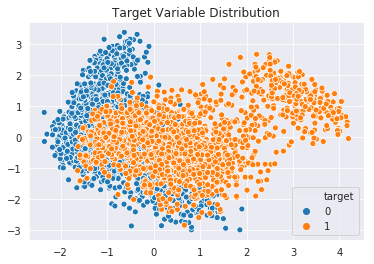

In [16]:
# reduce data to two dimensions
from sklearn.decomposition import PCA
Data_2D = PCA(n_components=2).fit_transform(Data)

sns.scatterplot(Data_2D[:,0], Data_2D[:,1], hue=target)
plt.title("Target Variable Distribution")
plt.show();

### Scale Data

In [15]:
Data.drop("explicit", axis=1, inplace=True)

Data_raw = Data.copy()
Data_emb_raw = Data_emb.copy()

from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
Data = scaler.fit_transform(Data)
Data = pd.DataFrame(Data, columns=Data_raw.columns)
Data['explicit'] = Audio_features['explicit'].astype("int")

Data_emb = scaler.fit_transform(Data_emb)
Data_emb = pd.DataFrame(Data_emb, columns=Data_emb_raw.columns)

Data.describe()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,999,1000,1001,1002,1003,1004,1005,1006,1007,1008,1009,1010,1011,1012,1013,1014,1015,1016,1017,1018,1019,1020,1021,1022,1023,acousticness,danceability,duration_ms,energy,instrumentalness,key,liveness,loudness,mode,popularity,speechiness,tempo,time_signature,valence,explicit
count,2990.000000,2990.000000,2990.000000,2990.000000,2990.000000,2990.000000,2990.000000,2990.000000,2990.000000,2990.000000,2990.000000,2990.000000,2990.000000,2990.000000,2990.000000,2990.000000,2990.000000,2990.000000,2990.000000,2990.000000,2990.000000,2990.000000,2990.000000,2990.000000,2990.000000,2990.000000,2990.000000,2990.000000,2990.000000,2990.000000,2990.000000,2990.000000,2990.000000,2990.000000,2990.000000,2990.000000,2990.000000,2990.000000,2990.000000,2990.000000,...,2990.000000,2990.000000,2990.000000,2990.000000,2990.000000,2990.000000,2990.000000,2990.000000,2990.000000,2990.000000,2990.000000,2990.000000,2990.000000,2990.000000,2990.000000,2990.000000,2990.000000,2990.000000,2990.000000,2990.000000,2990.000000,2990.000000,2990.000000,2990.000000,2990.000000,2990.000000,2990.000000,2990.000000,2990.000000,2990.000000,2990.000000,2990.000000,2990.000000,2990.000000,2990.000000,2990.000000,2990.000000,2990.000000,2990.000000,2990.000000
mean,0.447784,0.501948,0.564253,0.423146,0.567620,0.402528,0.501540,0.585015,0.560721,0.511011,0.506429,0.509443,0.440942,0.547279,0.596757,0.498572,0.458531,0.576142,0.587051,0.412615,0.548187,0.550772,0.618462,0.427398,0.462272,0.497970,0.527502,0.399682,0.412157,0.496677,0.494400,0.558347,0.541052,0.429396,0.488508,0.544842,0.591353,0.528764,0.368699,0.531697,...,0.426111,0.566497,0.548438,0.503996,0.552467,0.374038,0.452642,0.457767,0.416389,0.547755,0.553965,0.394503,0.529210,0.556308,0.480971,0.432775,0.664859,0.402390,0.451705,0.403512,0.475100,0.515805,0.491892,0.569311,0.599797,0.286470,0.541853,0.304413,0.618004,0.078404,0.480207,0.164700,0.741852,0.704348,0.378416,0.072383,0.459464,0.737375,0.434673,0.067224
std,0.147768,0.145644,0.136202,0.150952,0.174615,0.138798,0.128551,0.134766,0.135424,0.157025,0.137020,0.141363,0.163968,0.148000,0.148666,0.163511,0.132606,0.130195,0.140377,0.149901,0.153733,0.128137,0.114850,0.134200,0.129205,0.142866,0.139253,0.128899,0.122169,0.136202,0.130414,0.125303,0.151312,0.123352,0.150409,0.133358,0.138841,0.144898,0.143837,0.138919,...,0.144202,0.106244,0.146692,0.147398,0.132581,0.107810,0.135847,0.139052,0.122247,0.123818,0.149425,0.143900,0.130464,0.127126,0.113512,0.138021,0.119769,0.123248,0.132442,0.131659,0.141460,0.142246,0.155031,0.126245,0.143043,0.289535,0.145673,0.109314,0.205458,0.218966,0.327249,0.142005,0.128189,0.456412,0.257976,0.118630,0.182485,0.070155,0.248705,0.250452
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.339490,0.404452,0.474579,0.317677,0.449456,0.302697,0.413017,0.497577,0.473603,0.404256,0.414351,0.410845,0.329522,0.449015,0.495783,0.385876,0.368406,0.490807,0.498749,0.305475,0.445557,0.461562,0.545129,0.336615,0.375736,0.401935,0.437063,0.311005,0.329375,0.406483,0.406360,0.474999,0.439202,0.345226,0.387940,0.460966,0.499472,0.434851,0.271463,0.438184,...,0.321604,0.498181,0.455640,0.409285,0.468497,0.302268,0.361632,0.361376,0.334978,0.46657

### Model Feature Set

Features: embeddings

Training score: 1.0

Test score: 0.9505347593582888

Cross validation: 0.802 +/- 0.2062



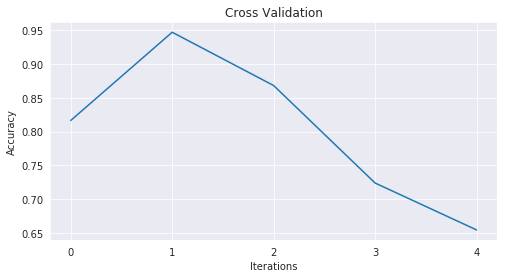

In [17]:
#from sklearn.ensemble import GradientBoostingClassifier
gbc = GradientBoostingClassifier(learning_rate=0.1)
model_desc.append("embeddings")
print("Features: {}".format(model_desc[-1]))

new_score = supervised_clf(model=gbc,
                           data=Data_emb,
                           target=target,
                           show_plot=True)
model_score = model_score.append(new_score, ignore_index=True)

Features: composite

Training score: 1.0

Test score: 0.9612299465240641

Cross validation: 0.8448 +/- 0.159



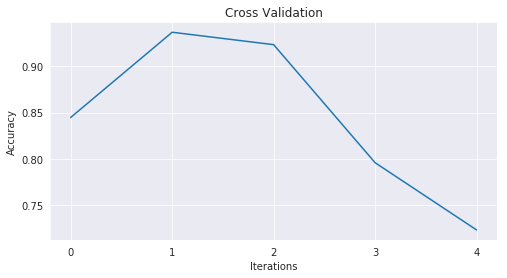

In [18]:
#from sklearn.ensemble import GradientBoostingClassifier
#gbc = GradientBoostingClassifier(learning_rate=0.1)
model_desc.append("composite")
print("Features: {}".format(model_desc[-1]))

new_score = supervised_clf(model=gbc,
                           data=Data,
                           target=target,
                           show_plot=True)
model_score = model_score.append(new_score, ignore_index=True)

### Assessment

In [19]:
model_score[["cv_score", "variance"]].describe()

,cv_score,variance
count,2.000000,2.000000
mean,0.823400,0.182600
std,0.030264,0.033375
min,0.802000,0.159000
25%,0.812700,0.170800
50%,0.823400,0.182600
75%,0.834100,0.194400
max,0.844800,0.206200


In [20]:
model_score = pd.concat([pd.Series(model_desc, name="features"), model_score], axis=1)
model_score.sort_values(by=["cv_score"], ascending=False)

,features,train_score,test_score,cv_score,variance
1,composite,1.0,0.961230,0.8448,0.1590
0,embeddings,1.0,0.950535,0.8020,0.2062


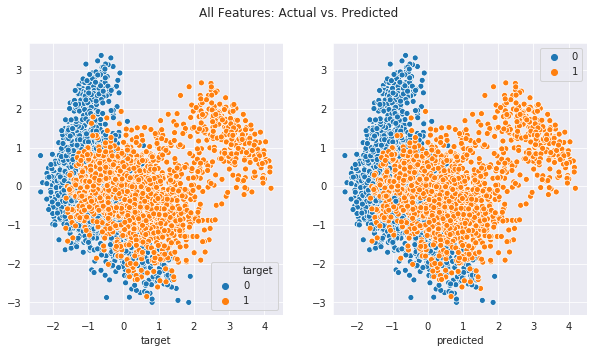

In [21]:
y_pred = gbc.predict(Data)
labels_list = [target, y_pred]
title_list=["target", "predicted", "All Features: Actual vs. Predicted"]
data=Data_2D
num_plots = range(0,2)
  
# plot target variable
fig, axes = plt.subplots(1, len(num_plots), figsize=(10,5))

for n in num_plots:
  sns.scatterplot(data[:,0], data[:,1],
                  hue=labels_list[n], ax=axes[n])
  axes[n].set_xlabel(title_list[n])

fig.suptitle(title_list[-1])
plt.show;

In [0]:
# plot confusion matrix
from sklearn.metrics import confusion_matrix
import itertools

#
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=0)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        #print("Normalized confusion matrix")
    else:
        1#print('Confusion matrix, without normalization')

    #print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Recall: 98.62164024810475%
Precision: 98.70967741935483%


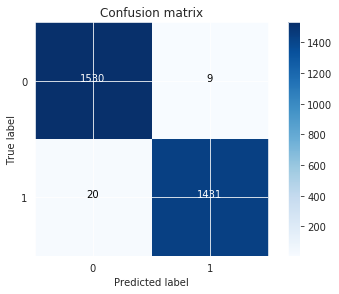

In [23]:
cnf_matrix = confusion_matrix(target, y_pred)

recall_metric = 100*cnf_matrix[1,1]/(cnf_matrix[1,0]+cnf_matrix[1,1])
print("Recall: {}%".format(recall_metric))

precision_metric = 100*cnf_matrix[0,0]/(cnf_matrix[0,0]+cnf_matrix[1,0])
print("Precision: {}%".format(precision_metric))

# Plot non-normalized confusion matrix
class_names = [0,1]
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names, title='Confusion matrix')
#plt.savefig('.png')
plt.show()

ROC-AUC: 0.995


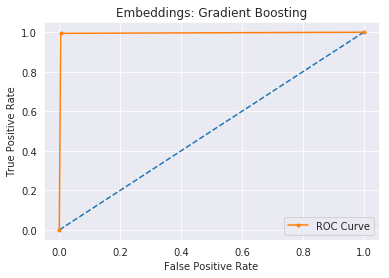

In [33]:
#from sklearn.metrics import roc_curve, roc_auc_score

# calculate AUC
roc_auc = roc_auc_score(target, y_pred)
print('ROC-AUC: %.3f' % roc_auc)
# calculate roc curve
fpr, tpr, thresholds = roc_curve(target, y_pred)

# plot no skill
plt.plot([0, 1], [0, 1], linestyle='--')
# plot the roc curve for the model
plt.plot(fpr, tpr, marker='.', label='ROC Curve')
plt.title('Embeddings: Gradient Boosting')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend()
#plt.savefig('.png')
plt.show()

f1=0.995 auc=0.996 ap=0.992


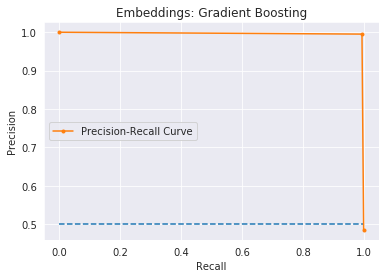

In [34]:
#from sklearn.metrics import precision_recall_curve, f1_score
#from sklearn.metrics import auc, average_precision_score

# calculate precision-recall curve
precision, recall, thresholds = precision_recall_curve(target, y_pred)
# calculate F1 score
F1_score = f1_score(target, y_pred)
# calculate precision-recall AUC
precision_recall_auc = auc(recall, precision)
# calculate average precision score
avg_precision = average_precision_score(target, y_pred)
print('f1=%.3f auc=%.3f ap=%.3f' % (F1_score,
                                    precision_recall_auc,
                                    avg_precision))

# plot no skill
plt.plot([0, 1], [0.5, 0.5], linestyle='--')
# plot the precision-recall curve for the model
plt.plot(recall, precision, marker='.', label='Precision-Recall Curve')
plt.title('Embeddings: Gradient Boosting')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend()
#plt.savefig('.png')
plt.show()

## Neural Network

In [0]:
def get_neural_network(data, node_list=[4,1], act_list=['relu', 'sigmoid'],
                       optimizer="adam", loss="binary_crossentropy",
                       metric_list=["accuracy"]):
  """
  """
  #  create neural network #####################################################
  #from keras import Sequential
  #from keras.layers import Dense
  model = Sequential()
  model.add(Dense(node_list[0], input_dim=data.shape[1], activation=act_list[0]))
  model.add(Dense(node_list[0], activation=act_list[0]))
  model.add(Dense(node_list[1], activation=act_list[1]))
  # Compile model ##############################################################
  model.compile(loss=loss, optimizer=optimizer, metrics=metric_list)

  return model

In [0]:
def get_ANN_clf(model, data, target, # data input
                test_size=0.25, stratify=True, cv=5, # split parameters
                batch_size=10, epochs=100, verbose=0, # training parameters
                show_scores=True
               ):
  """
  """
  # split data #################################################################
  #from sklearn.model_selection import train_test_split
  if stratify==True:
    X_train, X_test, y_train, y_test = train_test_split(
        data, target, test_size=test_size, stratify=target)
  else:
    X_train, X_test, y_train, y_test = train_test_split(
        data, target, test_size=test_size)
  
  # Train network ############################################################## 
  model.fit(X_train, y_train,
            batch_size=batch_size, epochs=epochs, verbose=verbose,
            validation_split=0.33)
  
  if show_scores==True:
    train_eval = model.evaluate(X_train, y_train)
    print("\nTraining accuracy: {}".format(train_eval[1]))

    test_eval = model.evaluate(X_train, y_train)
    print("\nTest accuracy: {}".format(test_eval[1]))
  
  return model

### Model Feature Sets

In [0]:
model = get_neural_network(Data_emb)
model = get_ANN_clf(model, Data_emb, target, verbose=1)

W0711 17:09:16.011451 140208702650240 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0711 17:09:16.061520 140208702650240 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0711 17:09:16.071418 140208702650240 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0711 17:09:16.124943 140208702650240 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/optimizers.py:790: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.

W0711 17:09:16.152337 140208702650240 deprecation_wrappe

Train on 1502 samples, validate on 740 samples
Epoch 1/100
1502/1502 [==============================] - 1s 712us/step - loss: 0.6965 - acc: 0.5732 - val_loss: 0.6663 - val_acc: 0.7554
Epoch 2/100
1502/1502 [==============================] - 0s 207us/step - loss: 0.6453 - acc: 0.7031 - val_loss: 0.6140 - val_acc: 0.8473
Epoch 3/100
1502/1502 [==============================] - 0s 205us/step - loss: 0.5788 - acc: 0.7650 - val_loss: 0.5326 - val_acc: 0.8122
Epoch 4/100
1502/1502 [==============================] - 0s 208us/step - loss: 0.5175 - acc: 0.8289 - val_loss: 0.4735 - val_acc: 0.8568
Epoch 5/100
1502/1502 [==============================] - 0s 203us/step - loss: 0.4604 - acc: 0.8522 - val_loss: 0.4414 - val_acc: 0.8216
Epoch 6/100
1502/1502 [==============================] - 0s 198us/step - loss: 0.4291 - acc: 0.8708 - val_loss: 0.4069 - val_acc: 0.9068
Epoch 7/100
1502/1502 [==============================] - 0s 216us/step - loss: 0.3875 - acc: 0.8908 - val_loss: 0.4227 - val_acc: 0

In [42]:
#from sklearn.model_selection import StratifiedKFold
kfold = StratifiedKFold(n_splits=5, shuffle=True)
cv_scores = []
for train, test in kfold.split(Data_emb, target):
  # create and compile model
	model = get_neural_network(Data_emb)
	# Fit the model
	model = get_ANN_clf(model, Data_emb, target, verbose=0, show_scores=False)
	# evaluate the model
	scores = model.evaluate(Data_emb, target, verbose=0)
	print("{}%: {}%".format(model.metrics_names[1], scores[1]*100))
	cv_scores.append(scores[1])

cv_mean = np.round(np.mean(cv_scores), 4)
variance = np.round(np.std(cv_scores)*2, 4)
print('\nCross validation: {} +/- {}\n'.format(cv_mean, variance))

acc%: 51.47157190635452%
acc%: 99.39799331103679%
acc%: 99.66555183946488%
acc%: 99.49832775919732%
acc%: 99.63210702341138%

Cross validation: 0.8993 +/- 0.3846



In [0]:
model = get_neural_network(Data)
model = get_ANN_clf(model, Data, target, verbose=1)

Train on 1502 samples, validate on 740 samples
Epoch 1/100
1502/1502 [==============================] - 7s 4ms/step - loss: 0.6955 - acc: 0.4867 - val_loss: 0.6931 - val_acc: 0.5324
Epoch 2/100
1502/1502 [==============================] - 1s 419us/step - loss: 0.6932 - acc: 0.5060 - val_loss: 0.6930 - val_acc: 0.5324
Epoch 3/100
1502/1502 [==============================] - 1s 421us/step - loss: 0.6932 - acc: 0.5060 - val_loss: 0.6928 - val_acc: 0.5324
Epoch 4/100
1502/1502 [==============================] - 1s 417us/step - loss: 0.6931 - acc: 0.5060 - val_loss: 0.6928 - val_acc: 0.5324
Epoch 5/100
1502/1502 [==============================] - 1s 434us/step - loss: 0.6932 - acc: 0.5060 - val_loss: 0.6928 - val_acc: 0.5324
Epoch 6/100
1502/1502 [==============================] - 1s 416us/step - loss: 0.6931 - acc: 0.5060 - val_loss: 0.6927 - val_acc: 0.5324
Epoch 7/100
1502/1502 [==============================] - 1s 419us/step - loss: 0.6932 - acc: 0.5060 - val_loss: 0.6927 - val_acc: 0.5

In [41]:
#from sklearn.model_selection import StratifiedKFold
kfold = StratifiedKFold(n_splits=5, shuffle=True)
cv_scores = []
for train, test in kfold.split(Data, target):
  # create and compile model
	model = get_neural_network(Data)
	# Fit the model
	model = get_ANN_clf(model, Data, target, verbose=0, show_scores=False)
	# evaluate the model
	scores = model.evaluate(Data, target, verbose=0)
	print("{}%: {}%".format(model.metrics_names[1], scores[1]*100))
	cv_scores.append(scores[1])

cv_mean = np.round(np.mean(cv_scores), 4)
variance = np.round(np.std(cv_scores)*2, 4)
print('\nCross validation: {} +/- {}\n'.format(cv_mean, variance))

acc%: 51.47157190635452%
acc%: 99.39799331103679%
acc%: 99.56521739130434%
acc%: 51.47157190635452%
acc%: 99.63210702341138%

Cross validation: 0.8031 +/- 0.4709



### Assessment

In [28]:
model = get_neural_network(Data_emb)
model = get_ANN_clf(model, Data_emb, target, verbose=0)
y_pred = model.predict(Data_emb)
y_pred =(y_pred>0.5).ravel()
#y_pred = np.where(y_pred==True, 1, 0)

W0713 23:18:45.077618 140327830325120 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0713 23:18:45.134944 140327830325120 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0713 23:18:45.143251 140327830325120 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0713 23:18:45.196269 140327830325120 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/optimizers.py:790: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.

W0713 23:18:45.222131 140327830325120 deprecation_wrappe

2242/2242 [==============================] - 0s 31us/step

Training accuracy: 0.9964317573595004
2242/2242 [==============================] - 0s 32us/step

Test accuracy: 0.9964317573595004


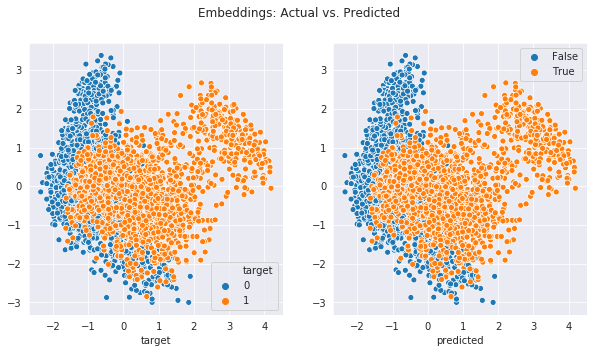

In [29]:
labels_list = [target, y_pred]
title_list=["target", "predicted", "Embeddings: Actual vs. Predicted"]
data=Data_2D
num_plots = range(0,2)
  
# plot target variable
fig, axes = plt.subplots(1, len(num_plots), figsize=(10,5))

for n in num_plots:
  sns.scatterplot(data[:,0], data[:,1],
                  hue=labels_list[n], ax=axes[n])
  axes[n].set_xlabel(title_list[n])

fig.suptitle(title_list[-1])
plt.show;

Recall: 99.4486560992419%
Precision: 99.48051948051948%


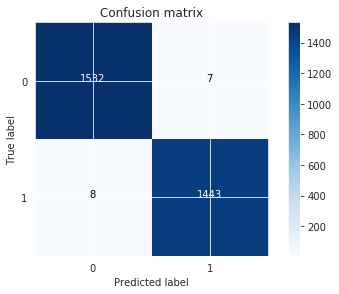

In [30]:
cnf_matrix = confusion_matrix(target, y_pred)

recall_metric = 100*cnf_matrix[1,1]/(cnf_matrix[1,0]+cnf_matrix[1,1])
print("Recall: {}%".format(recall_metric))

precision_metric = 100*cnf_matrix[0,0]/(cnf_matrix[0,0]+cnf_matrix[1,0])
print("Precision: {}%".format(precision_metric))

# Plot non-normalized confusion matrix
class_names = [0,1]
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names, title='Confusion matrix')
#plt.savefig('.png')
plt.show()

ROC-AUC: 0.995


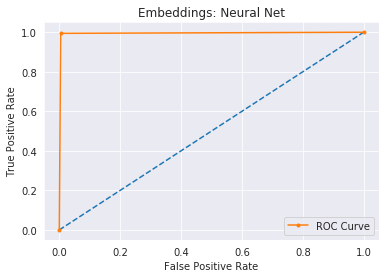

In [36]:
#from sklearn.metrics import roc_curve, roc_auc_score

# calculate AUC
roc_auc = roc_auc_score(target, y_pred)
print('ROC-AUC: %.3f' % roc_auc)
# calculate roc curve
fpr, tpr, thresholds = roc_curve(target, y_pred)

# plot no skill
plt.plot([0, 1], [0, 1], linestyle='--')
# plot the roc curve for the model
plt.plot(fpr, tpr, marker='.', label='ROC Curve')
plt.title('Embeddings: Neural Net')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend()
#plt.savefig('.png')
plt.show()

f1=0.995 auc=0.996 ap=0.992


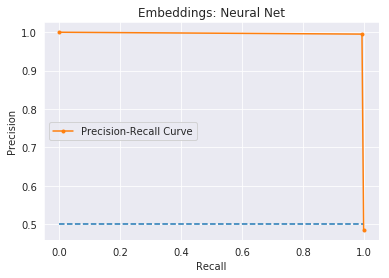

In [35]:
#from sklearn.metrics import precision_recall_curve, f1_score
#from sklearn.metrics import auc, average_precision_score

# calculate precision-recall curve
precision, recall, thresholds = precision_recall_curve(target, y_pred)
# calculate F1 score
F1_score = f1_score(target, y_pred)
# calculate precision-recall AUC
precision_recall_auc = auc(recall, precision)
# calculate average precision score
avg_precision = average_precision_score(target, y_pred)
print('f1=%.3f auc=%.3f ap=%.3f' % (F1_score,
                                    precision_recall_auc,
                                    avg_precision))

# plot no skill
plt.plot([0, 1], [0.5, 0.5], linestyle='--')
# plot the precision-recall curve for the model
plt.plot(recall, precision, marker='.', label='Precision-Recall Curve')
plt.title('Embeddings: Neural Net')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend()
#plt.savefig('.png')
plt.show()

## Conclusion

Both the supervised model and neural network exhibit *very* high accuracy, even after cross validation.
While impressive, this level of accuracy is **not practical** and likely a product of overfitting. The solution to this would be to increase the amount of data and retrain the model before putting it into production.

Between the two types of models (supervised vs. neural net), the supervised model was more stable and had less variance over multiple iterations.
The supervised model performed best when trained on a composite feature set of spotify data and contextual embeddings of lyric data.